#### Setup: Dependencies, Constants, and Seeding

This notebook uses a genetic algorithm that solves a TSP with 100 cities
that is imported from an internal module

In [18]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sys.path.append(os.getcwd())
from genetic_algorithm import genetic_algorithm

In [3]:
SEED = 42

## 1. Genetic Algorithm (GA)

Repeatedly simulates a random configuration for the Genetic Algorithm. 

In [4]:
results = []
n_runs = 1000

for i in range(n_runs):
    r = genetic_algorithm(
        crossover_rate=0.500,
        mutation_rate=0.001,
        elite_size=10,
        population_size=50,
        generations=300,
        seed=i,
    )
    results.append(r)

Distribution of best tour distance

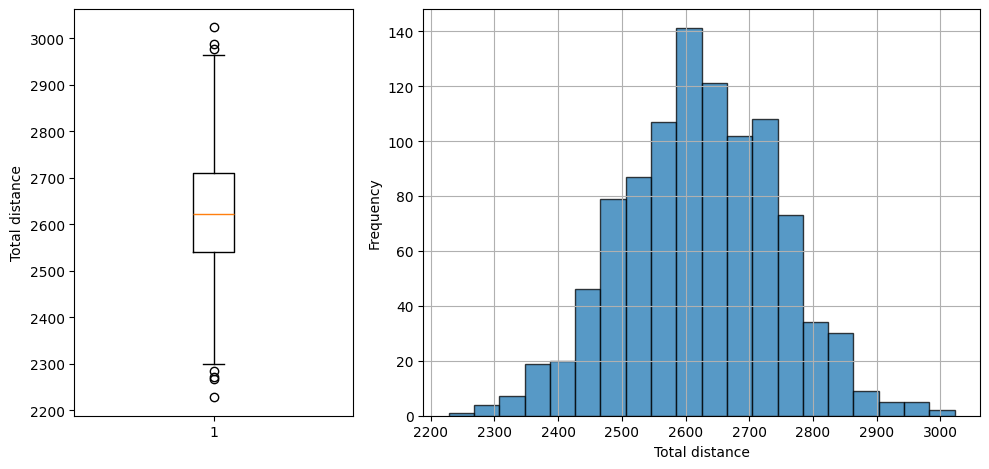

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 2]})

# Boxplot on the left (1/3 width)
axes[0].boxplot(results)
axes[0].set_ylabel("Total distance")
axes[0].grid(False)

# Histogram on the right (2/3 width)
axes[1].hist(results, bins=20, edgecolor="black", alpha=0.75)
axes[1].set_xlabel("Total distance")
axes[1].set_ylabel("Frequency")
axes[1].grid()

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

Stability of the mean of the best tour length

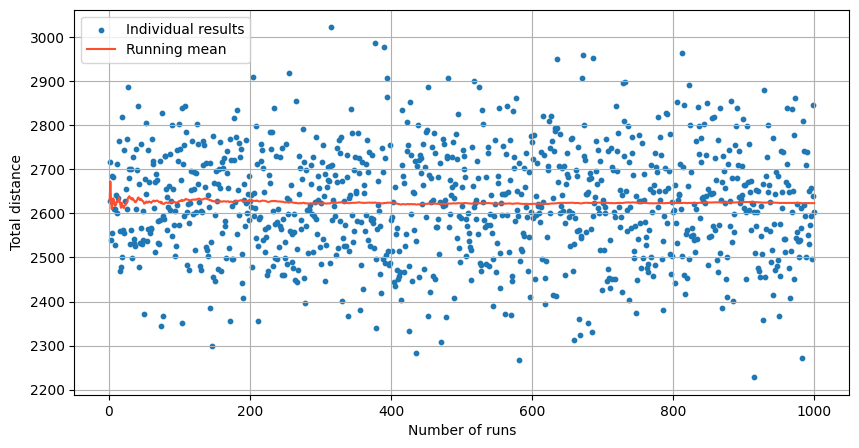

In [30]:
# Compute the running_means
results_index = np.arange(1, len(results) + 1)
running_means = np.cumsum(results) / results_index

# Scatter the individual results and plot the running_means
plt.figure(figsize=(10, 5))
plt.scatter(results_index, results, label="Individual results", s=10)
plt.plot(results_index, running_means, label="Running mean", color="#fc4f30")
plt.xlabel("Number of runs")
plt.ylabel("Total distance")
plt.grid()
plt.legend()
plt.show()

## 2. Optimization

### 2.1 Parameter Space

### 2.2 Optimization with EvoBandits

#### 2.3 Optimization with irace

## 3. Comparison